<a href="https://colab.research.google.com/github/Melisa7L/PPS/blob/main/Algoritmo_kmeans_PPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En base al codigo de la nube de la palabras realice modificaciones para que con las palabras frecuentes que se encontraron se pueda implementar el algoritmo kmeans generando clusters.

Librerias que se necesitan:

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install spacy

In [4]:
!pip install click

In [3]:
!pip install --upgrade click

In [5]:
!python -m spacy download es_core_news_sm

2023-11-17 12:06:29.768645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 12:06:29.768722: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 12:06:29.768753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 12:06:29.777535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 12:06:31.342829: W tensorflow/compiler/

Se construy√≥ la matriz de co-ocurrencia entre palabras en un contexto dado (dos palabras anteriores m√°s las dos palabras siguientes).
Se crean los vectores a partir de las filas de la matriz resultante.

VECTORIZACION

**k-means**  implementacion del algoritmo

In [6]:
!pip install scikit-learn

se va a probar con 500 registros solo por el tema de la memoria y ver que funciona el codigo:

In [7]:
import pandas as pd
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

# Leer el archivo XLSX que ya se limpi√≥ anteriormente
from google.colab import drive
drive.mount('/gdrive')

# Ruta del archivo en Google Drive
ruta = "/gdrive/My Drive/Limpieza/Data_Completo_Limpio.xlsx"

# Cargo el archivo Excel en un DataFrame de pandas
df = pd.read_excel(ruta)

# Lista de categor√≠as
categorias = df['categoria'].unique()

# Crear un diccionario para mapear categor√≠as a n√∫meros
categoria_a_numero = {cat: num for num, cat in enumerate(categorias)}

# Iterar sobre cada categor√≠a
for categoria in categorias:
    # Filtrar las filas que pertenecen a la categor√≠a espec√≠fica
    df_categoria = df[df['categoria'] == categoria]

    # Seleccionar aleatoriamente la cantidad de  registros del DataFrame
    df_sample = df_categoria.sample(n=500, random_state=42)

    # Analizar la columna de texto_noticia para la categor√≠a espec√≠fica
    text = ' '.join(df_sample['texto_noticia'].astype(str))

    # Normalizaci√≥n del texto
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    nlp = spacy.load('es_core_news_sm')
    nlp.max_length = len(text) + 100000
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if token.pos_ in ('NOUN', 'ADJ', 'VERB') and token.lemma_.lower() not in nlp.Defaults.stop_words]
    filtered_text = ' '.join(filtered_words)

    # Contar la frecuencia de las palabras utilizando un diccionario
    word_freq = Counter(filtered_words)

    # Guardar las palabras m√°s frecuentes en un archivo de texto con codificaci√≥n UTF-8
    with open(f'palabras_mas_frecuentes_{categoria}.txt', 'w', encoding='utf-8') as file:
        for word, freq in word_freq.most_common():
            file.write(f"{word}: {freq}\n")

    # Cargar las palabras m√°s frecuentes desde el archivo de texto
    palabras_mas_frecuentes = []
    with open(f'palabras_mas_frecuentes_{categoria}.txt', 'r', encoding='utf-8') as file:
        for line in file:
            palabra = line.split(":")[0].strip()
            palabras_mas_frecuentes.append(palabra)

    # Eliminar duplicados de la lista de palabras m√°s frecuentes
    palabras_mas_frecuentes = list(set(palabras_mas_frecuentes))

    # Vectorizaci√≥n con reducci√≥n de dimensionalidad mediante umbral de frecuencia (TF-IDF)
    vectorizer_tfidf = TfidfVectorizer(vocabulary=palabras_mas_frecuentes)
    X_tfidf = vectorizer_tfidf.fit_transform(df_sample['texto_noticia'])
    palabras_tfidf = vectorizer_tfidf.get_feature_names_out()

    # Aplicar K-Means
    num_clusters = 3  # Ajusta seg√∫n sea necesario
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df_sample['cluster'] = kmeans.fit_predict(X_tfidf)

    # Imprimir las palabras en cada cluster y su asociaci√≥n con la categor√≠a
    print(f"Palabras m√°s frecuentes en cada cluster para la categor√≠a {categoria}:")
    for cluster_num in range(num_clusters):
        cluster_words = [palabra for palabra in palabras_mas_frecuentes if kmeans.cluster_centers_[cluster_num][vectorizer_tfidf.vocabulary_[palabra]] > 0]
        print(f"Cluster {cluster_num} - Categor√≠a: {categoria_a_numero[categoria]}")
        print(cluster_words)
# Guardar los resultados de cada cluster en un archivo de texto
    with open(f'resultados_clusters_{categoria}.txt', 'w', encoding='utf-8') as result_file:
        for cluster_num in range(num_clusters):
            cluster_words = [palabra for palabra in palabras_mas_frecuentes if kmeans.cluster_centers_[cluster_num][vectorizer_tfidf.vocabulary_[palabra]] > 0]
            result_file.write(f"Cluster {cluster_num} - Categor√≠a: {categoria_a_numero[categoria]}\n")
            result_file.write(', '.join(cluster_words) + '\n\n')



Mounted at /gdrive


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a ciencia_tecnologia:
Cluster 0 - Categor√≠a: 0
['correcci√≥n', 'masivo', 'gama', 'negativo', 'lanier', 'microgravedad', 'electrodo', 'ligero', 'uvs', 'figura', 'meticulosamente', 'is', 'larva', 'remoto', 'europeo', 'oscuridad', 'akito', 'nodriza', 'exclusiva', 'exceso', 'eje', 'transmisi√≥n', 'cresta', 'inventario', 'apropiaci√≥n', 'constante', '2012', 'obsertorio', 'recuerda', 'corregir', 'lluvia', 'biotecnolog√≠a', 'cuesti√≥n', 'enigma', 'delicado', 'succi√≥n', 'ingenier√≠a', 'centrado', 'morfol√≥gico', 'plataforma', 'fluorescente', 'resistencia', 'mecss', 'imprimir', 'espiral', 'br√∫jula', 'pleno', 'nariz', 'fundamental', 'monte', 'astronomy', 'serpiente', 'polvoriento', 'duda', 'descrito', 'simple', 'pulpo', 'kombucha', 'bulbo', 'presente', 'diurno', 'banda', 'petrograf√≠a', 'prioridad', 'salinidad', 'insertado', 'se√±ala', 'sierra', 'establecer', 'agosto', '2013', 'cantalapiedra', 'caer', 'cosmolog√≠a', 'fagradalsfjall', '

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a cultura:
Cluster 0 - Categor√≠a: 1
['m√∫ltiple', 'sinopis', 'obligaci√≥n', 'correcci√≥n', 'gama', 'aut√©ntico', 'caixabank', 'negativo', 'veterano', 'cadencia', 'goizueta', 'proyectar', 'alusi√≥n', 'am√©rico', 'kelly', 'traductora', 'murcia', 'ligero', 'despertar', 'duprat', 'toy', 'figura', 'meticulosamente', 'sueiro', 'aura', 'turmalina', 'comanche', 'reflexionar', 'internalizaci√≥n', 'entretenido', 'hbo', 'piment√≥n', 'biopic', 'oscuridad', 'oferta', 'europeo', 'pintora', 'antolog√≠a', 'exclusiva', 'mitxel', '√°lvaro', 'despacito', 'eje', 'mandato', 'emporio', 'alba√±il', 'inventario', 'pase', 'informativo', 'constante', 'c√©lebre', 'autoritariamente', '2012', 'cantet', 'imax', 'murray', 'ganar', 'otorgado', 'pregunt√≥n', 'suceder', 'lalo', 'recuerda', 'corregir', 'casta√±a', 'certificado', 'lluvia', 'cuesti√≥n', 's√∫perventas', 'asamblea', 'torcer', 'tablaos', 'sully', 'envidia', 'deshonra', 'ingenier√≠a', 'centrado', 'ref

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a entretenimiento:
Cluster 0 - Categor√≠a: 2
['participante', 'gama', 'alusi√≥n', 'figura', 'reflexionar', 'tica', 'relax', 'exceso', 'cordobesa', 'disiente', 'transmisi√≥n', 'pase', 'sos', 'informativo', 'constante', '2012', 'ganar', 'cuesti√≥n', 'corear', 'envidia', 'marixa', 'balli', 'instagram', 'pleno', 'soledad', 'atarte', 'eva', 'fundamental', 'ida', 'marido', 'estabas', 'duda', 'arreglar', 'presente', 'banda', 'encanto', 'podr√≠as', 'talentoso', 'prioridad', 'agosto', '2013', 'caer', 'favorito', 'marcar', 'coraz√≥n', 'pol√©mica', 'previo', 'pretendo', 'esperar', 'romp√≠', 'fuerza', 'volver', 'madre', 'indagado', 'aspecto', 'maquilladora', 'dami√°n', 'inicio', 'sugerente', 'champagne', 'comcp√≥', 'silvina', 'personaje', 'hablar', 'brillar', 'retirado', 'civil', 'j√©sica', 'batalla', 'buzo', 'louis', 'sonrisa', 'pop', 'merced', 'sala', 'grupo', 'entrega', 'masculino', 'categ√≥rico', 'septiembre', 'pelopincho', 'figueroa', 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a educacion:
Cluster 0 - Categor√≠a: 3
['proyectar', 'alusi√≥n', 'aixa', 'figura', 'reflexionar', 'oferta', 'eje', 'mandato', 'escolarizaci√≥n', 'pase', 'recorrimos', 'cuesti√≥n', 'carrillo', 'confeccionar', 'centrado', 'presentamos', 'plataforma', '1000', 'vitro', 'pluralidad', 'secretar√≠a', 'eva', '22', 'fundamental', 'ida', 'concientizar', 'apaoa', 'n¬∫', 'articular', 'presente', 'panozzo', 'rousset', 'prioridad', 'nataci√≥n', 'establecer', 'agosto', '2013', 'recreaci√≥n', 'previo', 'did√°ctica', 'fuerza', 'volver', 'construcci√≥n', 'aspecto', 'difusi√≥n', 'massa', 'dami√°n', 'inicio', 'transformaci√≥n', 'intelectual', 'valorar', 'asumir', 'secretaria', 'fauna', 'ol√≠mpico', 'r√∫brica', 'sala', 'entrega', 'n¬∫145', 'septiembre', 'dialogar', 'racionalismo', 'orientador', 'trucco', 'inicial', 'decano', 'corolario', 'departamental', 'com√∫n', 'titular', 'emocional', 'seccional', 'productivista', 'querido', '2006', 'argentino', 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a medioambiente:
Cluster 0 - Categor√≠a: 4
['masivo', 'gama', 'negativo', 'ligero', 'helio', 'constante', 'lluvia', 'cuesti√≥n', 'delicado', 'storage', 'ingenier√≠a', 'centrado', 'resistencia', 'exponer', 'fundamental', 'astronomy', 'aventura', 'simple', 'banda', '2013', 'recreaci√≥n', 'marcar', 'sanitaria', 'recolectada', 'escorrent√≠a', 'aspecto', 'ricarte', 'co2', 'africano', 'longitudinal', 'explotaci√≥n', 'frenar', 'aridez', 'inspiraci√≥n', 'grupo', 'city', 'mortandad', 'flexibilidad', 'pr√≥spero', 'identificar', 'consumidor', 'carb√≥n', 'medioambiental', 'monitorizar', 'texto', 'com√∫n', 'modelo', 'coautor', 'utilizado', 'consiguiente', 'formaci√≥n', 'abarata', 'enfrentado', 'lacustre', 'vasta', 'invernadero', 'etc', 'global', 'ciclo', '1992', 'parque', 'actividad', 'mosquito', 'descubrimiento', 'procesamiento', 'categorizaci√≥n', 'derechos', 'islands', 'el√©ctrica', 'ieo', 'biomedicina', 'valor', 'cosmo', 'pr√°ctica', 've

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a politica:
Cluster 0 - Categor√≠a: 5
['escrutinio', 'obligaci√≥n', 'alusi√≥n', 'figura', 'violatorio', 'mandato', 'transmisi√≥n', 'ganar', 'suceder', 'destac', 'certificado', 'cuesti√≥n', 'anticip', 'confeccionar', 'manzur', '1000', 'pod', 'secretar√≠a', '22', 'fundamental', 'retroactivo', 'veda', 'encuestador', 'presente', 'ingres√°', 'agosto', 'marcar', 'esperar', 'fuerza', 'estallar', 'volver', 'difusi√≥n', 'massa', 'visual', 'inicio', 'procedimiento', 'esc', 'hablar', 'pueblo', 'asumir', 'plantilla', 'entrega', 'pondr', 'ocultamiento', 'septiembre', 'figueroa', 'milei', 'hotel', 'identificar', 'com√∫n', 'argentino', 'marra', 'inflaci√≥n', 'oficial', 'renovaci√≥n', 'libreta', 'adentro', 'limpiar', 'solano', 'ubicar', 'formaci√≥n', 'deuda', '2704', 'justificado', 'recuento', 'cortar', 'contingencia', 'constatar', 'fondo', 'moneda', 'venta', 'pagado', 'diciembre', 'actividad', '√§√∫en', 'impresi√≥n', 'federico', 'dedo', 'fallo

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a horoscopo:
Cluster 0 - Categor√≠a: 6
['obligaci√≥n', 'masivo', 'aut√©ntico', 'negativo', 'proyectar', 'ligero', 'despertar', 'eslab√≥n', 'figura', 'distraer√°s', 'aura', 'reflexionar', 'entretenido', 'oscuridad', 'exceso', 'desempe√±o', 'informativo', 'afilar', 'constante', '2012', 'ganar', 'suceder', 'darte', 'adelantar', 'corregir', 'lluvia', 'cuesti√≥n', 'delicado', 'envidia', 'lanzarte', 'centrado', 'alcaid√≠a', 'plataforma', 'empate', 'emerger', 'resistencia', 'ver√°', 'instagram', 'exponer', 'elucidarioprovee', 'pleno', 'soledad', 'medalla', 'harto', 'fundamental', 'serpiente', 'aventura', 'evadir', 'estabas', 'duda', 'descrito', 'pelear√°s', 'arreglar', 'ocuparte', 'simple', 'concientizar', 'articular', 'afirmarte', 'gozar', 'arsenal', 'presente', 'conquiste', 'encanto', 'podr√≠as', 'cometer', 'prioridad', 'alejarte', 'confort', 'deseabas', 'capricho', 'establecer', 'agosto', '2013', 'conc√©ntrate', 'caer', 'mediar', 's

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a deportes:
Cluster 0 - Categor√≠a: 7
['obligaci√≥n', 'aixa', 'figura', 'briasco', 'santino', 'oferta', 'pintora', 'desempe√±o', 'otamendi', 'inmejorable', 'cordobesa', 'transmisi√≥n', 'pase', 'sos', '2012', 'ganar', 'atletic', 'cuesti√≥n', 'manzur', 'empate', 'chiarini', 'instagram', 'exv√©lez', 'pleno', 'secretar√≠a', 'medalla', '22', 'fundamental', 'monte', 'ir√°n', 'tute', 'ida', 'duda', 'arsenal', 'presente', 'banda', 'valdiviezo', 'prioridad', 'nataci√≥n', 'agosto', 'causalidad', 'reemplazado', 'caer', 'recreaci√≥n', 'marcar', 'clasificar', 'previo', 'v√≥ley', 'esperar', 'terreno', 'fuerza', 'comercial', 'volver', 'madre', 'aspecto', 'juniors', 'b√∫falo', 'reafirmar', 'aburrido', 'inicio', 'especialidad', 'semifinal', 'riestra', 'inglaterra', 'zapla', 'reclam', 'tilcara', 'sabala', 'pueblo', 'inspiraci√≥n', 'pu√±ado', 'asumir', 'batalla', 'secretaria', 'intensidad', 'sonrisa', 'cayetano', 'ol√≠mpico', 'cruzado', 'merced', 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a economia:
Cluster 0 - Categor√≠a: 8
['escrutinio', 'sudafricano', 'obligaci√≥n', 'masivo', 'gama', 'aut√©ntico', 'negativo', 'hamptons', 'proyectar', 'alusi√≥n', 't√©lam', 'kelly', 'dom', 'diagnostico', 'ligero', 'despertar', 'eslab√≥n', '√∏por', 'figura', 'fijaci√≥n', 'nurphoto', 'federalizar', 'pronunci', 'a24', 'isepci', 'gal√≥n', 'remoto', 'oferta', 'europeo', 'oscuridad', 'autob√∫s', 'numero', 'exceso', 'pagar√©', 'desempe√±o', 'eje', 'cordobesa', 'mandato', 'transmisi√≥n', 'clasificada', 'pase', 'kilo', 'constante', 'c√©lebre', '2012', 'ecoansiedad', 'tedio', 'murray', 'bayraktar', 'ganar', 'otorgado', 'suceder', 'acumulamos', 'profit', 'destac', 'darte', 'recuerda', 'adelantar', 'corregir', 'lluvia', 'certificado', 'biotecnolog√≠a', 'refrigerador', 'cuesti√≥n', 'reticencia', 'asamblea', 'boeing', 'delicado', 'zuckerberg', 'anticip', 'muera', 'government', 'ingenier√≠a', 'centrado', 'pentomino', 'presentamos', 'plataform

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a salud:
Cluster 0 - Categor√≠a: 9
['t√©lam', 'requerimiento', 'otamendi', 'transmisi√≥n', 'ostom√≠a', 'fundamental', 'concientizar', 'sanitaria', 'madre', 'sala', 'grupo', 'it', 'frecuente', 'titular', 'argentino', 'm√©dica', 'oficial', 'paper', 'global', 'covid', 'aborto', 'diciembre', 'actividad', 'derechos', 'pr√°ctica', 'trabajo', 'c√≥rdoba', 'accidente', 'mes', 'senador', 'da√±o', '69', 'cerebro', 'acarrea', 'flujo', 'reuni√≥n', 'g√©nero', 'obra', '2020', 'sistema', 'riesgo', 'investigaci√≥n', 'viral', 'respuesta', 'gastron√≥mico', 'congreso', 'materia', 'estable', 'anticonceptivo', 'respirar', 'izquierdo', 'desarrollar', 'com', 'relaciones', 'sandro', 'ten√©s', 'realizamos', 'sexto', 'provincia', 'card√≠aca', 'tabaquismo', '2022', 'm√©todo', 'twitter', 'legionella', 'cultural', 'prevenir', 'normal', 'curar', 'jefa', 'rosario', 'tr√°nsito', 'umbilical', 'alcohol', 'bacteria', 'aparici√≥n', 'sector', 'legal', 'prevenci√≥n',

A continuacion se representara mediante graficos los resultados:

Histogramas de Frecuencia de Palabras:
A traves de este grefico se puede observar la frecuencia de las palabras en cada cluster. Ayuda a tener idea de cuales son las palabras que se repiten mas por categoria.

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a ciencia_tecnologia:
Cluster 0 - Categor√≠a: 0
['calidad', 'cubierta', 'masivo', 'id√≥neo', 'empresa', 'publicado', 'procesamiento', 'controvertido', 'medida', 'corriente', 'frase', 'cuadrados', 'comercio', 'parcela', 'inmersi√≥n', 'superar', 'computaci√≥n', 'est√≠mulo', 'universidad', 'posterior', 'fallo', 'dominante', 'update', 'sitio', 'tiempo', 'seguido', 'faceta', 'correo', 'bbc', 'subir', 'investigating', 'listado', 'valor', 'publicitario', 'compra', 'experiencia', 'usuario', 'compa√±√≠a', 'propiedad', 'adquisitivo', 'consecuencia', 'prensa', 'aparentar', 'mostrar', 'representante', 'sensorizaci√≥n', 'ciudadan√≠a', 'interior', 'praxis', 'plegable', 'punto', 'cuesti√≥n', 'regi√≥n', 'impresa', 'estrategia', 'local', 'pil', 'fidelity', 'trabajo', 'funcional', 'plataforma', 'clave', 'mercado', 'enero', 'domicilio', 'ofrecer', 'trascendencia', 'ca√≠da', 'solicitud', 'planteamiento', 'fundamental', 'joystick', 'roblox', 'adelan

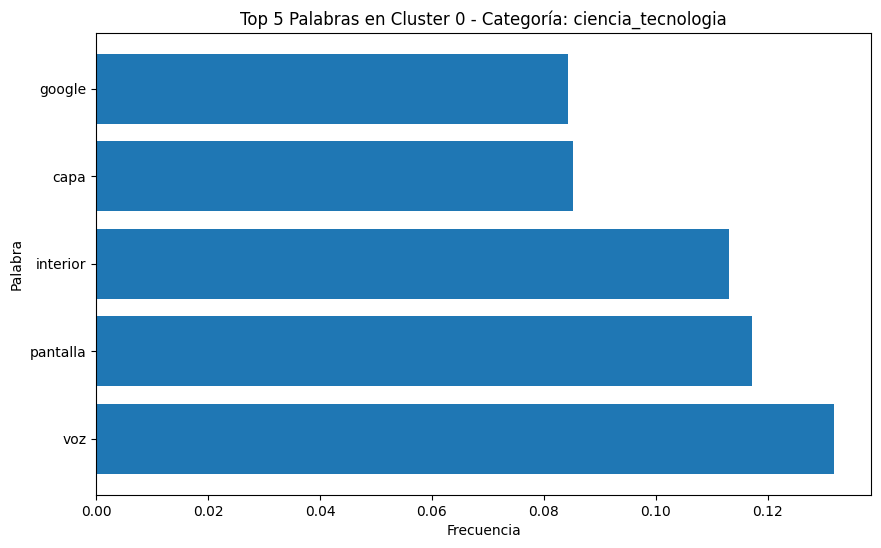

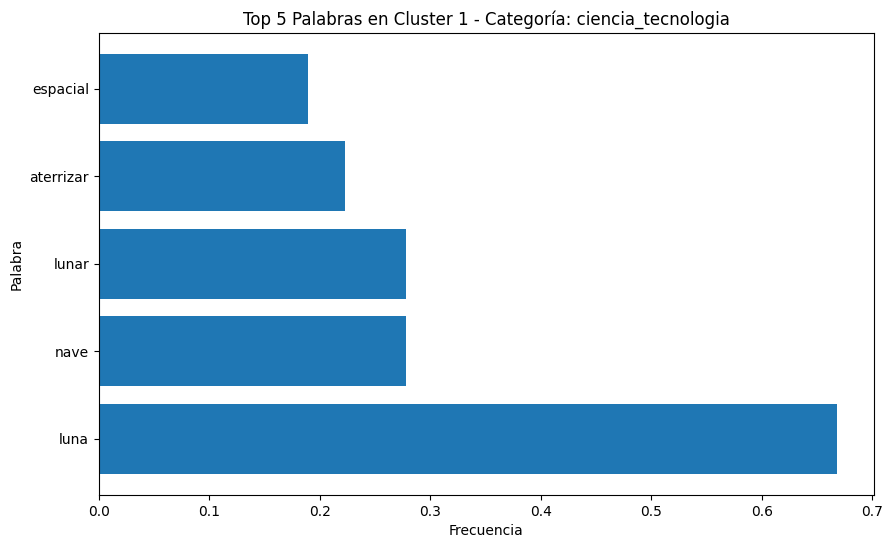

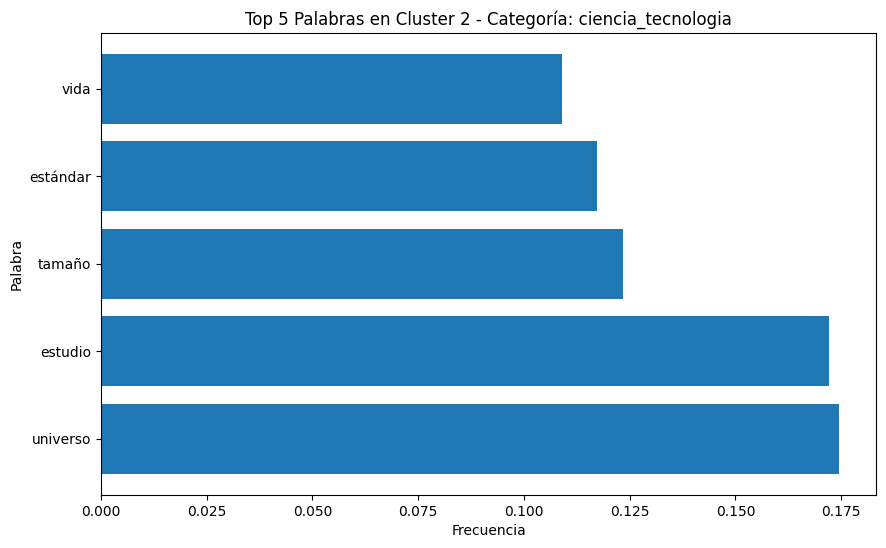

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a cultura:
Cluster 0 - Categor√≠a: 1
['mejora', 'actividad', 'hist√≥rico', 'inagotable', 'reconocimiento', 'divulgaci√≥n', 'lengua', 'm√≠nimo', 'universidad', 'tiempo', 'oferta', 'filmoteca', 'anual', '1984', 'inventario', 'compa√±√≠a', 'ley', 'isla', 'grifo', 'puesto', 'titularidad', 'concedido', 'iluminaci√≥n', 'profesora', 'comunidad', 'referencia', 'web', 'relevancia', 'labor', 'destacar', 'parar', 'revalorizar', 'creaci√≥n', 'rural', 'presente', 'finlandia', 'licenciada', 'protecci√≥n', 'secci√≥n', 'establecido', 'base', 'p√©rez', 'reunido', 'extraordinario', 'as', 'deriva', 'barco', 'lenguaje', 'zaragoza', 'actuaci√≥n', 'restauraci√≥n', 'previo', 'invertir', '1959', 'euros', 'lema', 'nivel', 'pa√≠s', 'multidisciplinar', 'premio', 'promoci√≥n', 'difusi√≥n', 'redifusi√≥n', 'audio', 'actualidad', 'carmen', 'coherente', 'concepci√≥n', 'administrativo', 'galardonar', 'edici√≥n', 'derogar', 'zigor', 'cine', 'rehabilitar', 'trans

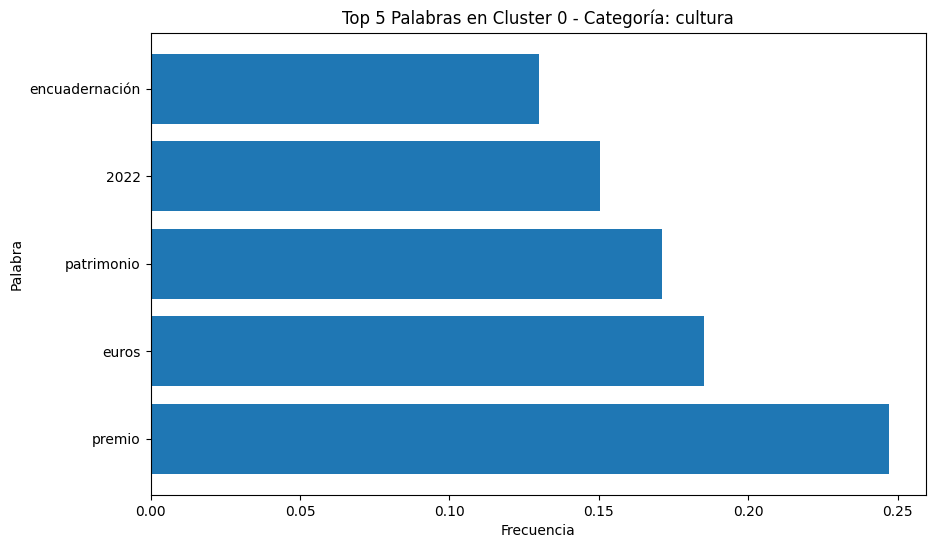

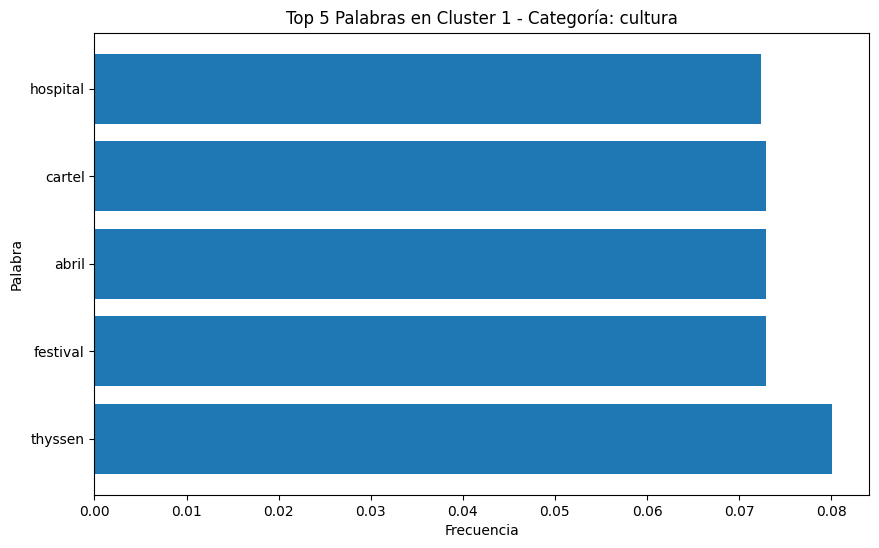

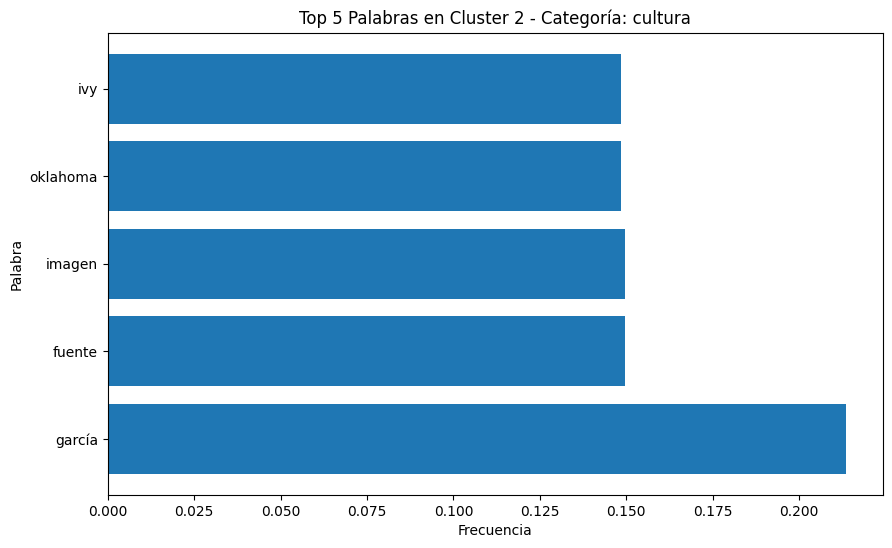

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a entretenimiento:
Cluster 0 - Categor√≠a: 2
['indicado', 'calidad', 'idea', 'comer', 'usuaria', 'lugar', 'vino', 'usuario', 'experiencia', 'excelente', 'mostrar', 'cuesti√≥n', 'econ√≥mico', 'hora', 'postre', 'lia', 'liafoodba', 'capital', 'social', '2000', 'esposa', 'video', 'encontrar', 'ubicado', 'compartir', 'men√∫', 'mujer', 'reserva', 'sorprendio', 'septiembre', 'pod√©s', 'armado', 'virgilio', 'pesos', 'cena', 'costillar', 'influencer', 'precio', 'pena', 'morcilla', 'crema', '6800', 'tiktok', 'parrilla', '2023', 'ciudad', 'recibir', 'accesible', 'red', 'acceder', 'reproducciones', 'durazno', 'asado', 'chorizo', 'restaurante']
Cluster 1 - Categor√≠a: 2
['gigante', 'vegano', 'cuerpo', 'neumann', 'hermana', 'tiempo', 'oferta', 'paula', 'entra√±able', 'curar', 'model', 'recuperar', 'descanso', 'fabi√°n', 'noche', 'paz', 'exterior', 'pr√°ctica', 'cubero', 'tronco', 'perfil', 'borde', 'mica', 'instagram', 'ofrecer', 'marca', 'in

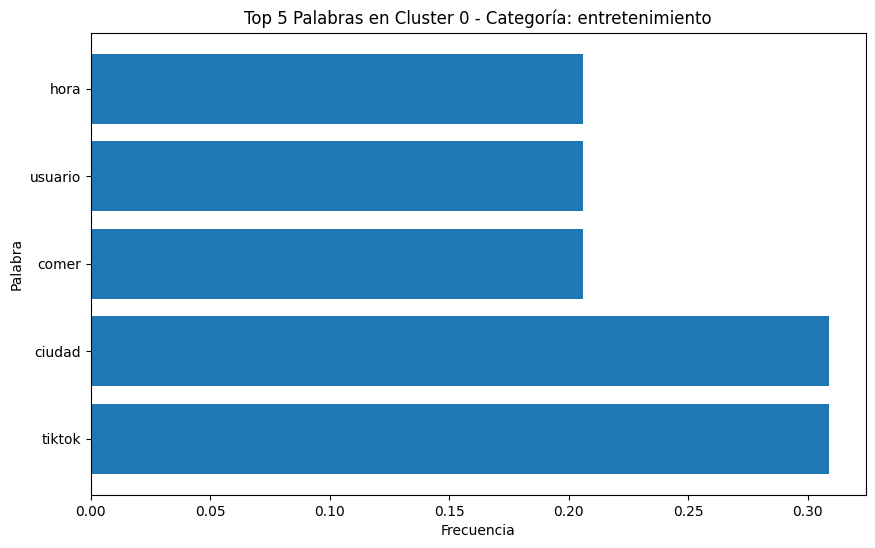

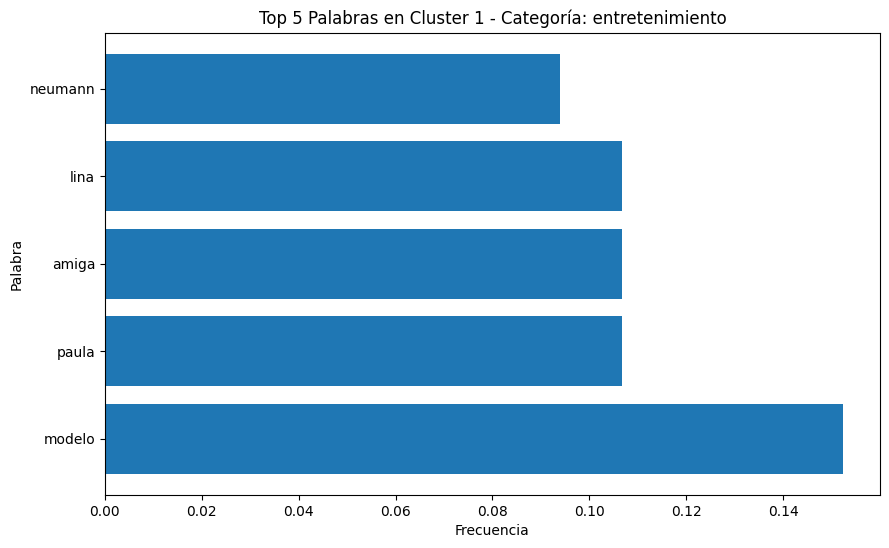

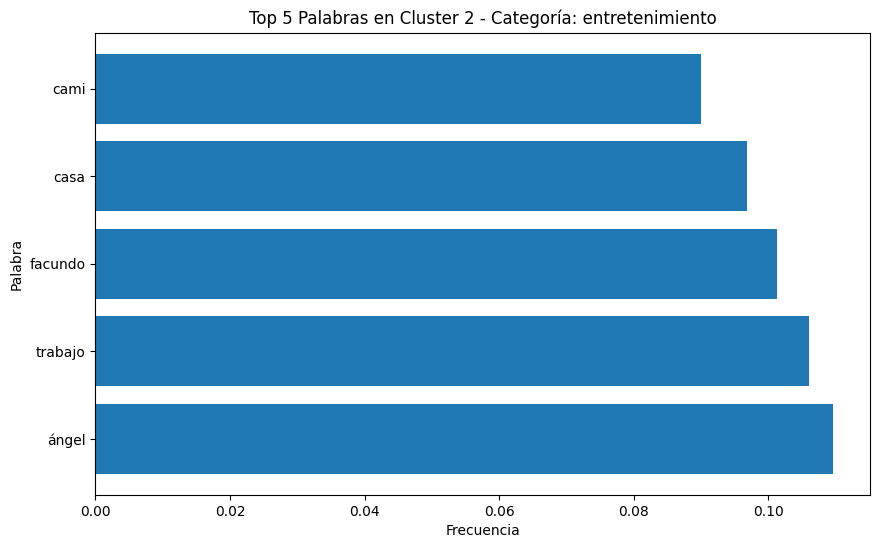

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a educacion:
Cluster 0 - Categor√≠a: 3
['calidad', 'actividad', 'equipo', 'grupal', 'presidenta', 'taller', 'entregar', 'medida', 'provincia', 'lugar', 'madera', 'programaci√≥n', 'tiempo', 'jujuy', 'conocimiento', 'federaci√≥n', 'desempe√±o', 'excelente', 'secundaria', 'resoluci√≥n', 'instruir', 'carrillo', 'relevamiento', 'trabajo', 'participaci√≥n', 'conjunto', 't√©cnica', 'puesto', 'armar', 'decisi√≥n', 'planificaci√≥n', 'fundamental', '2016', 'comunidad', 'iraz√°bal', 'rol', 'n¬∫5', 'herramienta', 'comienzo', 'cge', 'funcionamiento', 'savio', 'mes', 'empezar', 'base', 'salta', 'jefe', 'personal', 'principal', 'albornoz', 'f√°brica', 'creatividad', 'capacitaci√≥n', 'momento', 'liz√°rraga', 'nivel', 'pa√≠s', 'sector', 'carpinter√≠a', 'premio', 'construcci√≥n', 'conformado', 'martin', 'fabricamos', 'dependiente', 'anal√≠tico', 'dr', 'escuela', '2019', 'menor', 'funci√≥n', 'posici√≥n', 'docente', 'resolver', 'especialidad', 'dur

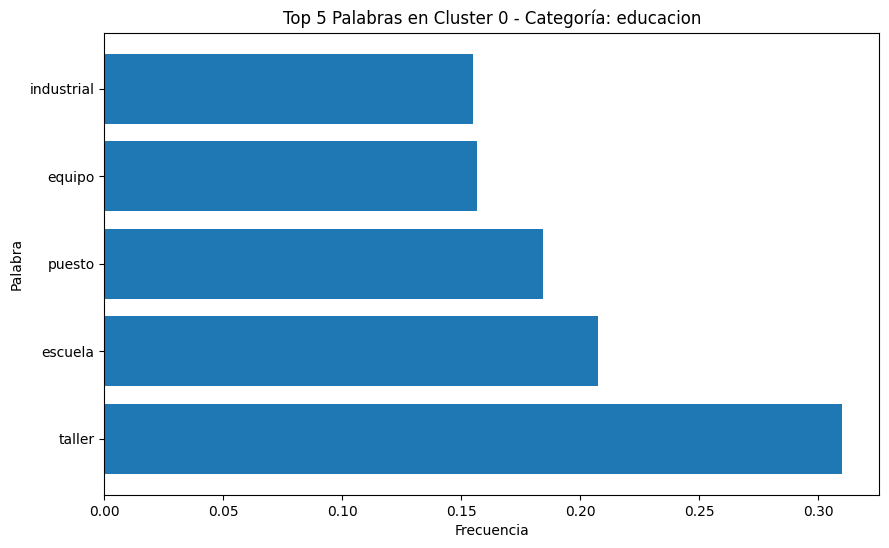

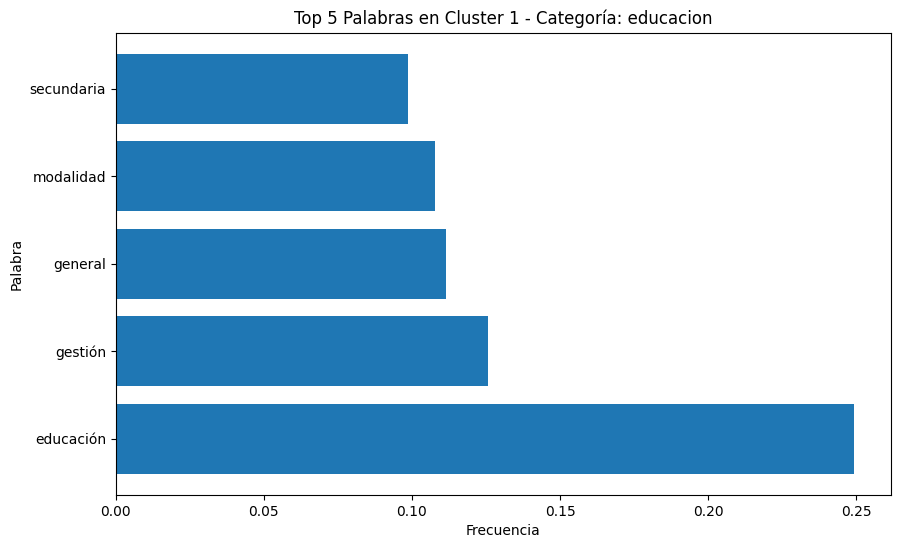

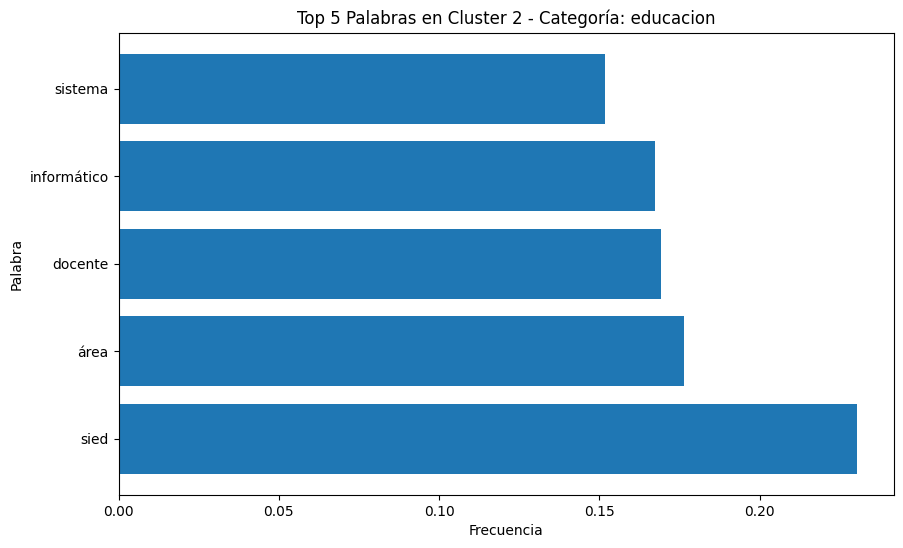

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a medioambiente:
Cluster 0 - Categor√≠a: 4
['injusta', 'europeo', 'listado', 'ampare', 'constante', 'compa√±√≠a', 'prensa', 'cuesti√≥n', 'supremo', 'estrategia', 'expansi√≥n', 'marido', 'web', 'finlandia', 'le√≥n', 'establecer', 'di√°logo', 'previo', 'abierto', 'redifusi√≥n', 'inconstitucional', 'problema', 'chino', 'catalogaci√≥n', 'conflicto', 'norma', 'competencia', 'umbral', 'amon√≠aco', 'gasoducto', 'grupo', 'oficio', 'ganader√≠a', 'reducir', 'septiembre', 'propuesto', 'regionalista', 'territorial', 'facto', 'texto', 'c√°ntabro', 'com√∫n', 'titular', 'popular', 'cifra', 'mitad', 'duquesa', 'propuesta', 'aras', 'ministerio', 'comisi√≥n', 'cohesi√≥n', 'veintisiete', 'gracias', 'consideraci√≥n', 'fondo', 'desarrollo', 'territorio', 'plan', 'conservaci√≥n', 'acercamiento', 'corral', 'marcha', 'duero', 'actividad', 'xunta', 'correr', 'universidad', 'acci√≥n', 'lugo', 'ley', 'regresi√≥n', 'suecia', 'comunidad', 'proponer', 'ambie

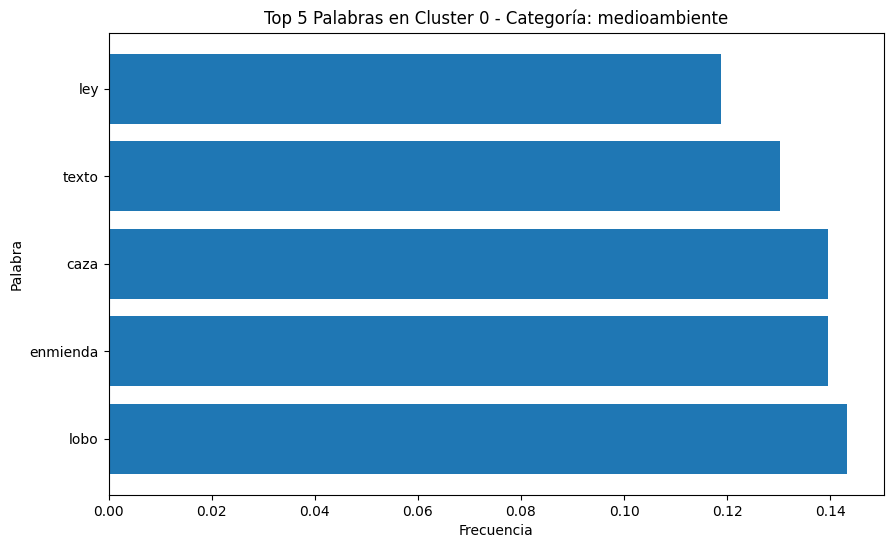

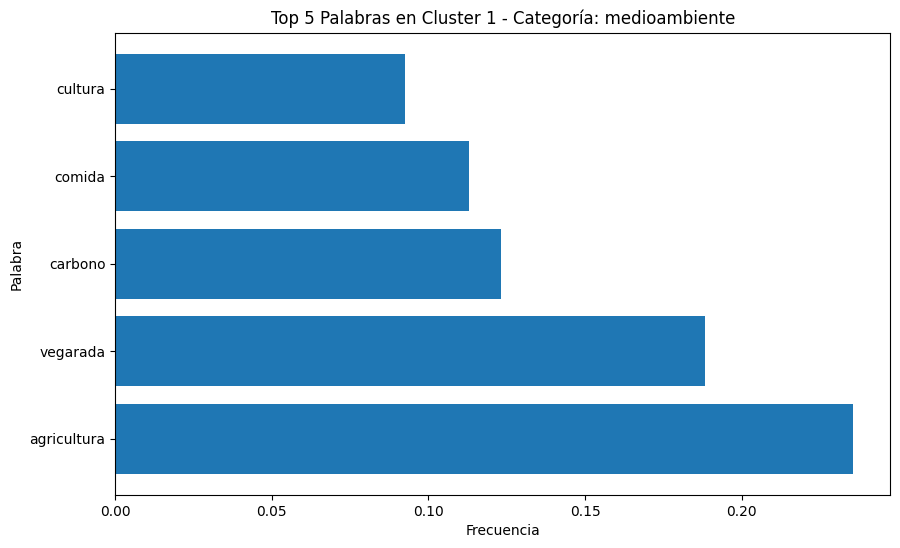

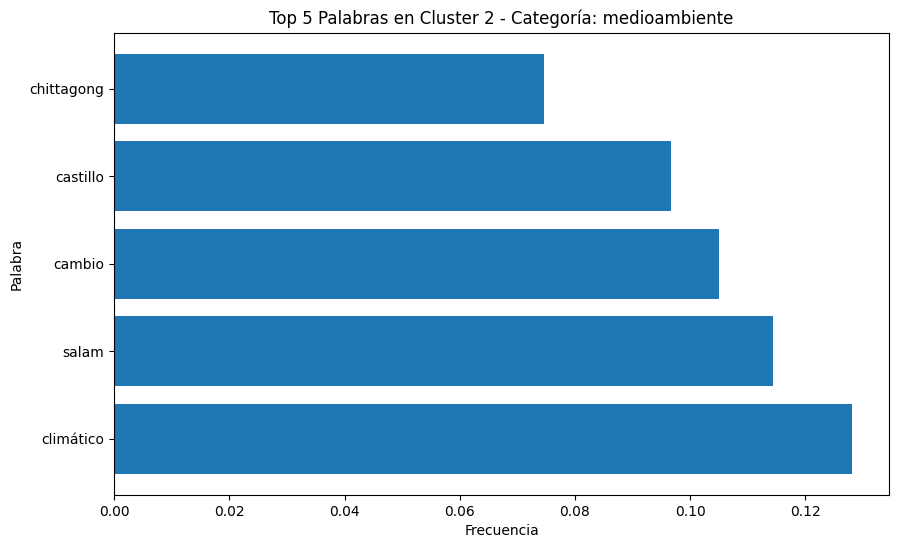

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a politica:
Cluster 0 - Categor√≠a: 5
['escrutinio', 'tecn√≥crata', 'masivo', 'semana', 'proyectar', 'alusi√≥n', 'lugar', 'electo', 'superar', 'opacar', 'eje', 'estadio', 'apropiaci√≥n', 'radicalismo', 'ganar', 'deslizar', 'jefa', 'interior', 'cuesti√≥n', 'impresa', 'estrategia', 'muera', 'santafesino', 'plataforma', 'candidato', 'resistencia', 'dato', 'exponer', 'soledad', 'veda', 'comienzo', 'arsenal', 'minimizar', 'directorio', 'ganador', 'bid', 'agosto', 'axel', 'di√°logo', 'f√°brica', 'coraz√≥n', 'ordenar', 'pol√©mica', 'previo', 'empresario', 'peronista', 'esperar', 'terreno', 'pa√≠s', 'fuerza', 'sector', 'macri', 'financiado', 'mapa', 'voto', 'massa', 'legal', 'gasto', '2019', 'monetario', 'inicio', 'edici√≥n', 'anunciar', 'bajar', 'auto', 'cuervo', 'problema', 'intelectual', 'campa√±a', 'pueblo', '2017', 'batalla', 'fuerte', 'oposici√≥n', 'reprogramar', 'retomar', 'grupo', 'kirchnerista', 'maxipullaro', 'septiembre', 'di

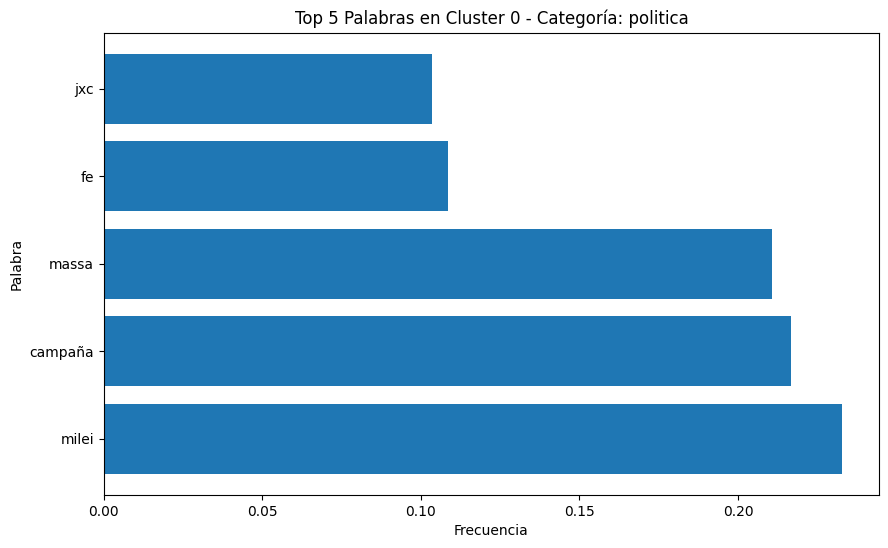

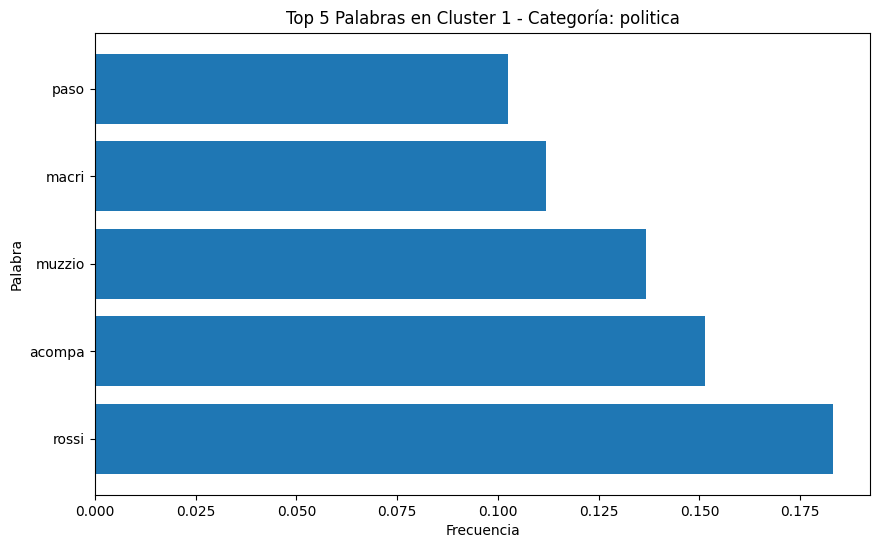

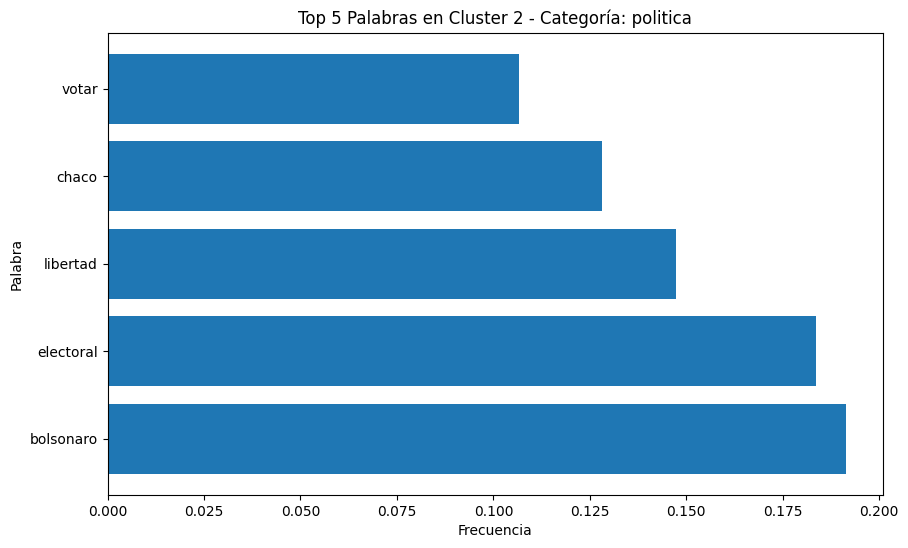

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a horoscopo:
Cluster 0 - Categor√≠a: 6
['mejora', 'suerte', 'tendencia', 'conciencia', 'actividad', 'equipo', 'mejorar', 'semana', 'copyright', 'empresa', 'domingo', 'confianza', 'per√≠odo', 'ligero', 'comercio', 'tiempo', 'arte', 'uni√≥n', 'temporada', 'signo', 'g√©minis', 'valor', 'informativo', 'inesperado', 'propiedad', 'jornada', 'ley', 'estabilidad', 'excelente', 'librarte', 'sol', 'art√≠culo', 'expresamos', 'interior', 'crear', 'paz', 'punto', 'inevitable', 'oportunidad', 'destino', 'poderoso', 'hora', 'traer', 'piscis', 'horizonte', 'determinaci√≥n', 'afrontar', 'instagram', 'se√±al', 'alegr√≠a', 'expansi√≥n', 'escorpio', 'acuario', 'urano', 'period√≠stico', 'preocupaci√≥n', 'web', 'hor√≥scopo', 'zodiaco', 'abundancia', 'araoz', 'radical', 'mes', 'alejamiento', 'ambiente', 'influencia', 'empezar', 'confiar', 'amor', 'establecer', 'tauro', 'tr√°nsito', 'armonioso', 'virgo', 'transmitir', 'coraz√≥n', 'retr√≥grado', 'enfoca

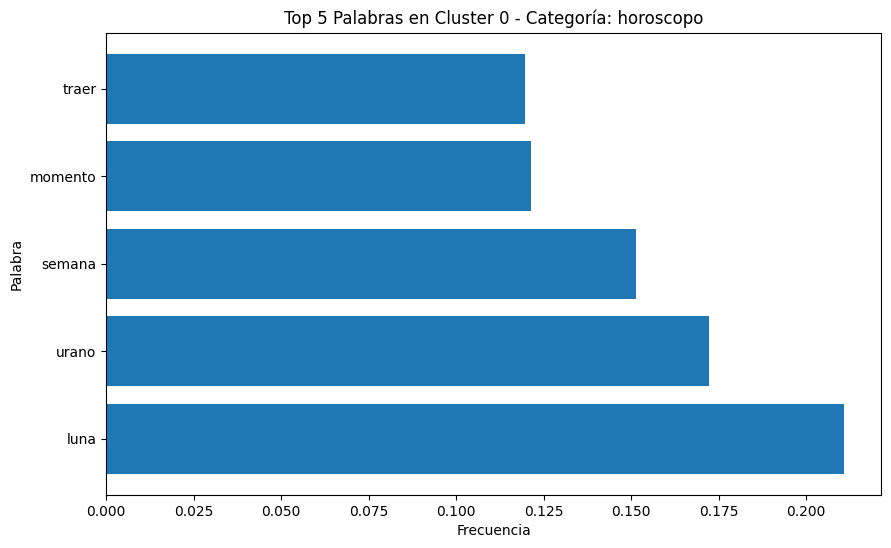

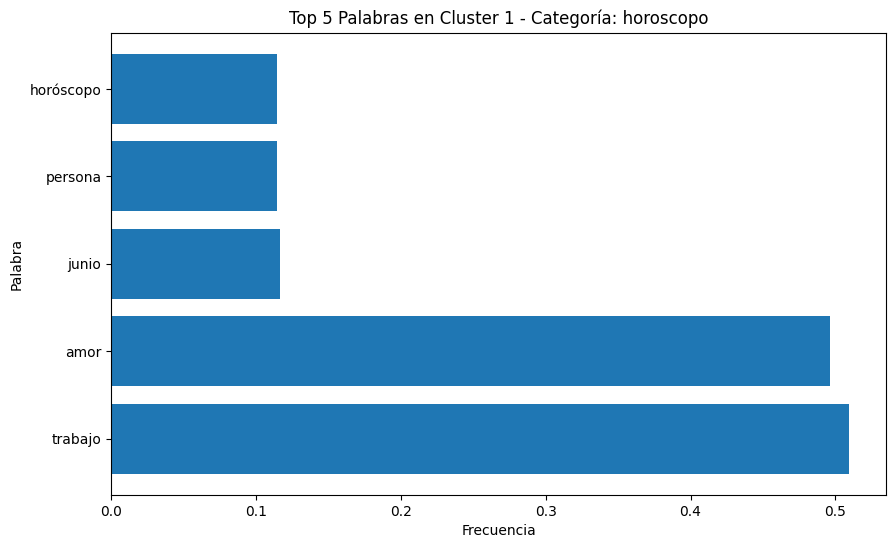

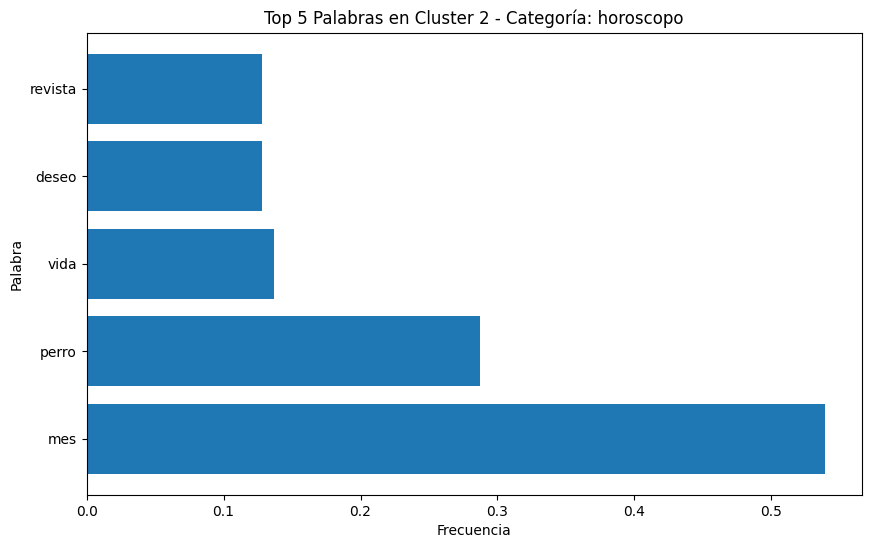

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a deportes:
Cluster 0 - Categor√≠a: 7
['suerte', 'island√©s', 'ciclismo', '2024', 'giro', 'equipo', 'mejorar', 'contrato', 'tiempo', 'reciente', 'temporada', 'transparencia', 'desfibrilador', 'experiencia', 'jugador', 'aceptar', 'corredor', 'corregir', 'worldtour', 'aegir', 'urte', 'hijo', 'markel', 'competir', 'afrontar', 'universitario', 'belga', 'itzulia', 'web', 'donostia', 'preparatorio', 'amistoso', 'base', 'firma', 'zaragoza', 'hooydonck', 'coraz√≥n', 'guipuzcoano', 'anomal√≠a', 's√°bado', 'nivel', 'volver', 'mundial', 'mapa', 'norteamericano', 'legal', 'paternidad', 'contacto', 'hospital', 'futuro', 'utziko', 'utilizar', 'carrera', 'joven', 'fichaje', 'eitb', 'firefox', 'enorme', 'mi√©rcoles', 'lesi√≥n', 'euskaraz', 'campeonato', 'contento', 'interno', 'privacidad', 'liga', 'aviso', 'visualizaci√≥n', 'septiembre', 'tobillo', 'tour', 'julio', 'batengatik', 'exciclista', 'objetivo', 'rapidez', 'proveniente', 'categor√≠a', 

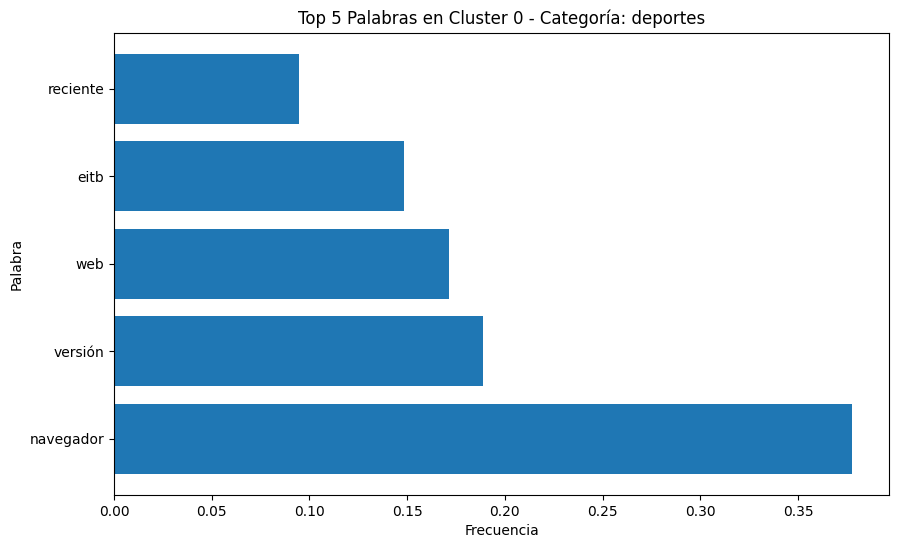

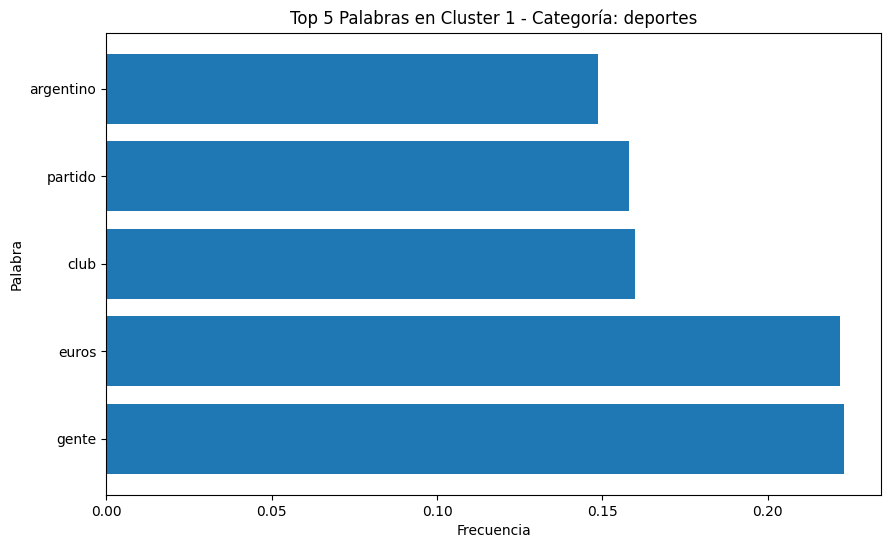

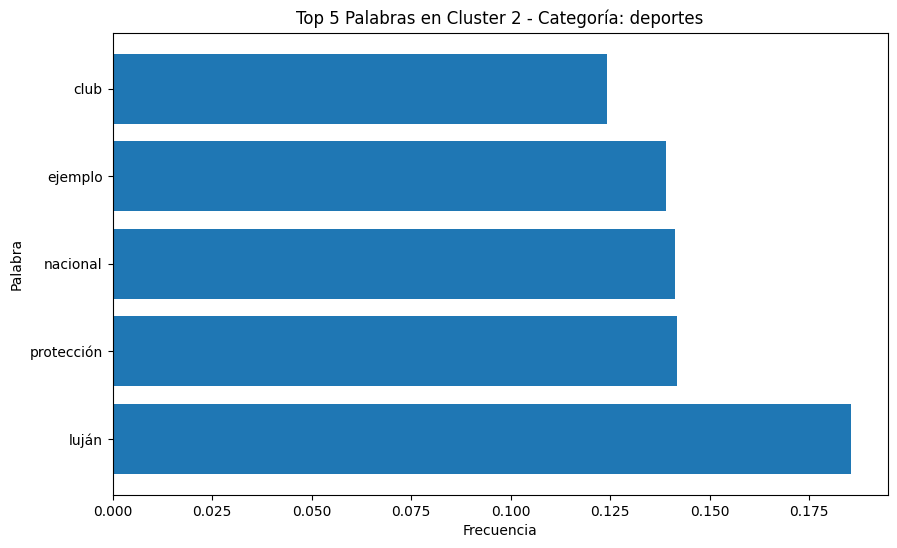

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a economia:
Cluster 0 - Categor√≠a: 8
['despertar', 'necesidad', 'suceder', 'destac', 'plata', 'arreglar', 'cpc', 'escasez', 'ordenar', 'entrar', 'sector', 'paciente', 'massa', 'mirar', 'frenar', 'espalda', 'problema', 'ccl', 'ampli', 'milei', 'alto', 'informal', '√§√∫no', 'titular', 'centro', 'equilibrio', 'directivo', 'mbito', 'fiscal', 'presidente', 'apuesta', 'empresarial', 'fija', 'motivo', 'diciembre', 'ciclo', 'sufrimos', 'idea', 'celebrado', 'ley', 'particip', 'mercado', 'horizonte', 'liderar', 'coloquio', 'escalada', 'tributario', 'jefe', 'fuga', 'promesa', 'actual', 'encontrar', 'gobernador', 'construir', 'critic', 'octubre', 'respeta', 'generar', 'suma', 'resultado', '√§√∫esto', 'miedo', 'mirada', 'uia', 'sistema', 'argentina', 'evidente', 'salida', 'suspender', 'metros', 'real', 'mundo', 'otorgar', 'litio', 'rbita', 'ombligo', 'serie', 'privado', 'industria', 'imposible', 'carg', 'llano', 'entidad', '√§√∫que', 'mejor

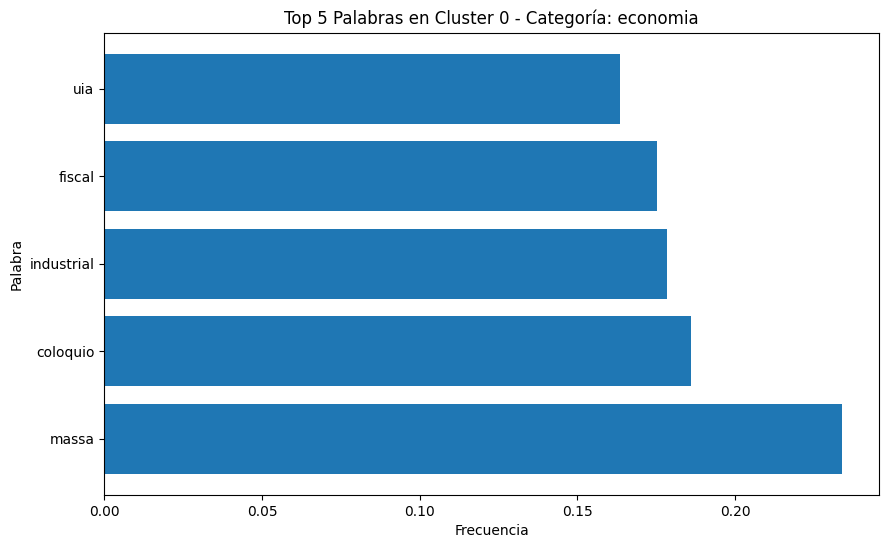

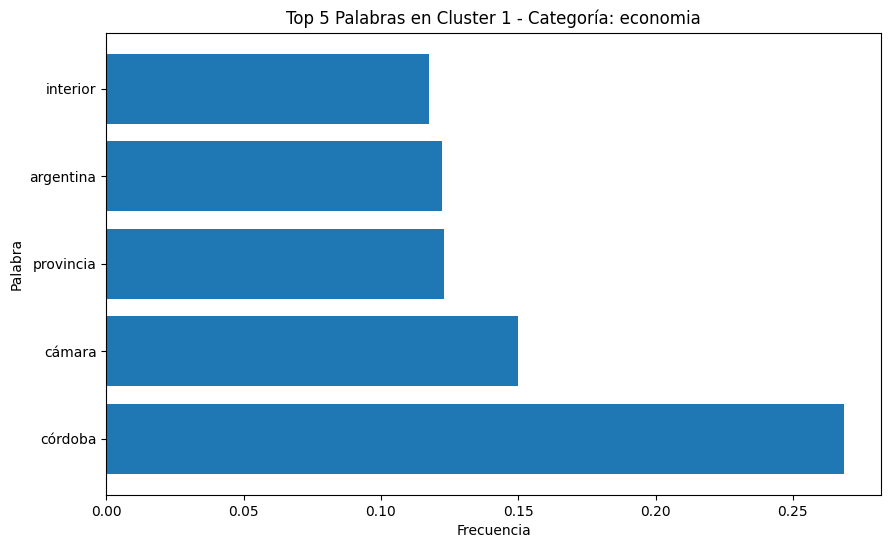

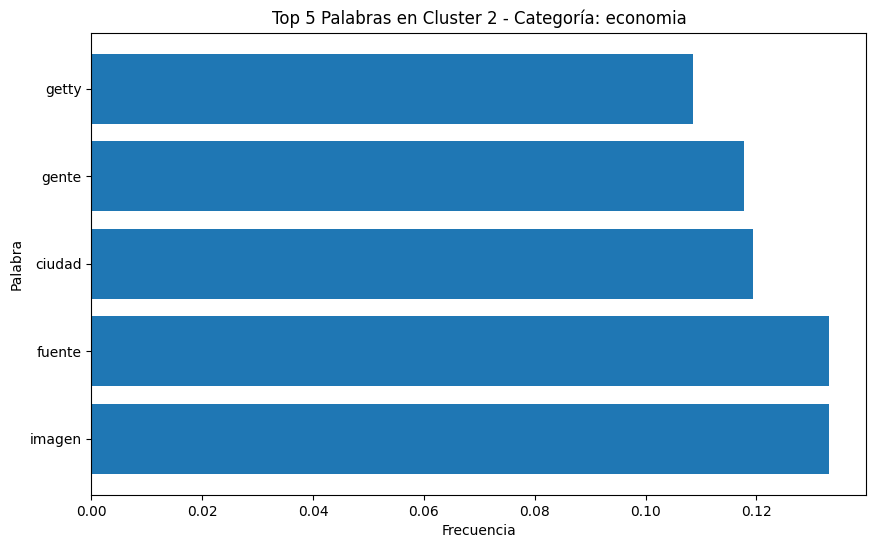

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Palabras m√°s frecuentes en cada cluster para la categor√≠a salud:
Cluster 0 - Categor√≠a: 9
['suerte', 'quir√≥fano', 'semana', 'intestinal', 'getty', 'corriente', 'original', 'autob√∫s', 'bbc', 'exceso', 'necesidad', 'obstetricia', 'sol', 'suceder', 'amni√≥tico', 'interior', 'comida', 'mantener', 'impresa', 'cama', 'parecer', 'ingenier√≠a', 'grasa', 'imagenolog√≠a', 'deterioro', 'nariz', 'fundamental', 'evadir', 'gana', '√°lgebra', 'referencia', 'galleta', 'beber', 'presente', 'prioridad', 'p√©rez', 'ocupado', 'f√°brica', 'milagro', 'alcohol', 'dibutilesta√±o', 'hospitalizaci√≥n', 'esperar', 'aparici√≥n', 'pa√≠s', 'sector', 'vejez', 'paciente', 'volver', 'madre', 'sencillo', 'aspecto', 'legal', 'sobrepeso', 'probable', 'gasto', 'fetal', 'edici√≥n', 'masa', 'bajar', 'adelgazar', 'liberaci√≥n', 'problema', 'quemado', 'intelectual', 'sonda', 'pl√°stico', 'estiramiento', 'hambre', 'historia', 'bloqueo', 'tejido', 'garantizar', '2021', 'sala', 'grupo', 'soler', 'microbiota', 'plazo', 'inte

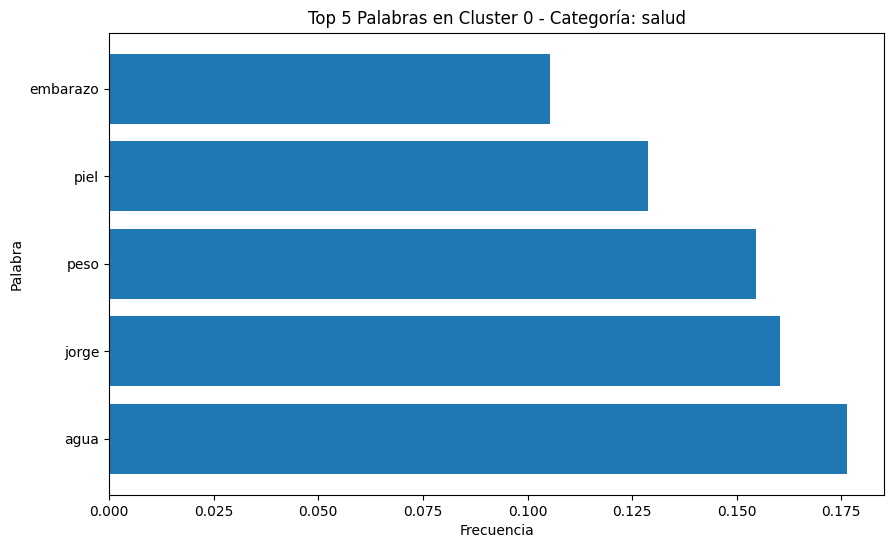

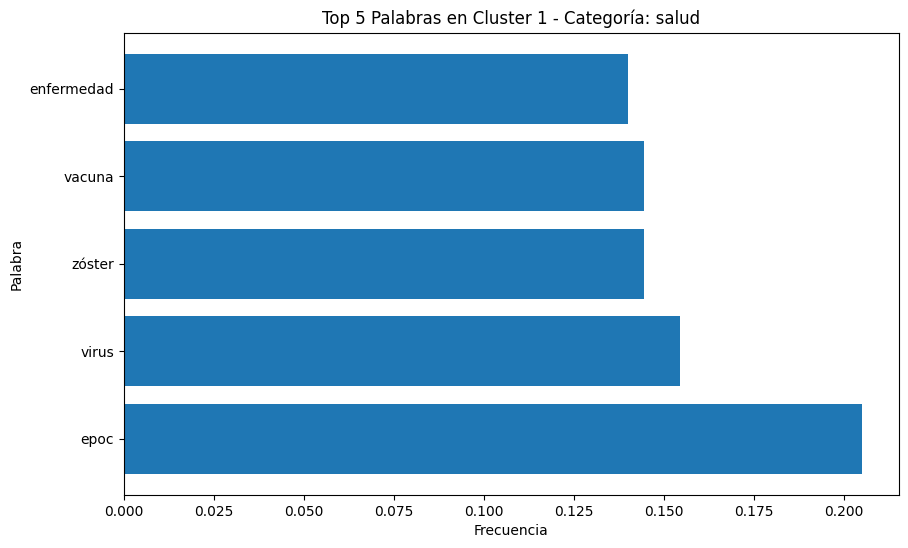

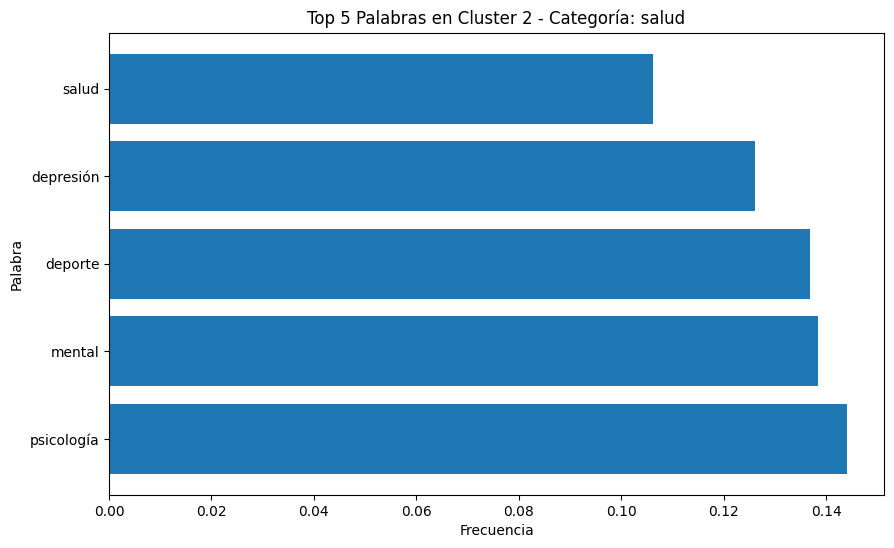

In [24]:
import pandas as pd
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

# Leer el archivo XLSX que ya se limpi√≥ anteriormente
from google.colab import drive
drive.mount('/gdrive')

# Ruta del archivo en Google Drive
ruta = "/gdrive/My Drive/Limpieza/Data_Completo_Limpio.xlsx"

# Cargo el archivo Excel en un DataFrame de pandas
df = pd.read_excel(ruta)

# Lista de categor√≠as
categorias = df['categoria'].unique()

# Crear un diccionario para mapear categor√≠as a n√∫meros
categoria_a_numero = {cat: num for num, cat in enumerate(categorias)}

# Iterar sobre cada categor√≠a
for categoria in categorias:
    # Filtrar las filas que pertenecen a la categor√≠a espec√≠fica
    df_categoria = df[df['categoria'] == categoria]

    # Seleccionar aleatoriamente la cantidad de  registros del DataFrame
    df_sample = df_categoria.sample(n=10, random_state=42)

    # Analizar la columna de texto_noticia para la categor√≠a espec√≠fica
    text = ' '.join(df_sample['texto_noticia'].astype(str))

    # Normalizaci√≥n del texto
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    nlp = spacy.load('es_core_news_sm')
    nlp.max_length = len(text) + 100000
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if token.pos_ in ('NOUN', 'ADJ', 'VERB') and token.lemma_.lower() not in nlp.Defaults.stop_words]
    filtered_text = ' '.join(filtered_words)

    # Contar la frecuencia de las palabras utilizando un diccionario
    word_freq = Counter(filtered_words)

    # Guardar las palabras m√°s frecuentes en un archivo de texto con codificaci√≥n UTF-8
    with open(f'palabras_mas_frecuentes_{categoria}.txt', 'w', encoding='utf-8') as file:
        for word, freq in word_freq.most_common():
            file.write(f"{word}: {freq}\n")

    # Cargar las palabras m√°s frecuentes desde el archivo de texto
    palabras_mas_frecuentes = []
    with open(f'palabras_mas_frecuentes_{categoria}.txt', 'r', encoding='utf-8') as file:
        for line in file:
            palabra = line.split(":")[0].strip()
            palabras_mas_frecuentes.append(palabra)

    # Eliminar duplicados de la lista de palabras m√°s frecuentes
    palabras_mas_frecuentes = list(set(palabras_mas_frecuentes))

    # Vectorizaci√≥n con reducci√≥n de dimensionalidad mediante umbral de frecuencia (TF-IDF)
    vectorizer_tfidf = TfidfVectorizer(vocabulary=palabras_mas_frecuentes)
    X_tfidf = vectorizer_tfidf.fit_transform(df_sample['texto_noticia'])
    palabras_tfidf = vectorizer_tfidf.get_feature_names_out()

    # Aplicar K-Means
    num_clusters = 3  # Ajusta seg√∫n sea necesario
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df_sample['cluster'] = kmeans.fit_predict(X_tfidf)

    # Imprimir las palabras en cada cluster y su asociaci√≥n con la categor√≠a
    print(f"Palabras m√°s frecuentes en cada cluster para la categor√≠a {categoria}:")
    for cluster_num in range(num_clusters):
        cluster_words = [palabra for palabra in palabras_mas_frecuentes if kmeans.cluster_centers_[cluster_num][vectorizer_tfidf.vocabulary_[palabra]] > 0]
        print(f"Cluster {cluster_num} - Categor√≠a: {categoria_a_numero[categoria]}")
        print(cluster_words)
# Guardar los resultados de cada cluster en un archivo de texto
    with open(f'resultados_clusters_{categoria}.txt', 'w', encoding='utf-8') as result_file:
        for cluster_num in range(num_clusters):
            cluster_words = [palabra for palabra in palabras_mas_frecuentes if kmeans.cluster_centers_[cluster_num][vectorizer_tfidf.vocabulary_[palabra]] > 0]
            result_file.write(f"Cluster {cluster_num} - Categor√≠a: {categoria_a_numero[categoria]}\n")
            result_file.write(', '.join(cluster_words) + '\n\n')

 # Iterar sobre cada cluster
    for cluster_num in range(num_clusters):
        # Obtener las palabras m√°s frecuentes en el cluster actual
        cluster_words = [palabra for palabra in palabras_mas_frecuentes if kmeans.cluster_centers_[cluster_num][vectorizer_tfidf.vocabulary_[palabra]] > 0]

        # Ordenar las palabras por frecuencia y tomar las 5 m√°s frecuentes
        top_words = sorted(cluster_words, key=lambda palabra: kmeans.cluster_centers_[cluster_num][vectorizer_tfidf.vocabulary_[palabra]], reverse=True)[:5]
        top_frequencies = [kmeans.cluster_centers_[cluster_num][vectorizer_tfidf.vocabulary_[word]] for word in top_words]

        # Crear un gr√°fico de barras para las 5 m√°s frecuentes
        plt.figure(figsize=(10, 6))
        plt.barh(top_words, top_frequencies)
        plt.title(f"Top 5 Palabras en Cluster {cluster_num} - Categor√≠a: {categoria}")
        plt.xlabel('Frecuencia')
        plt.ylabel('Palabra')
        plt.show()

Grafico 2D de los Clusters:
Se usan t√©cnicas de reducci√≥n de dimensionalidad como PCA o t-SNE para visualizar los clusters en un gr√°fico 2D.

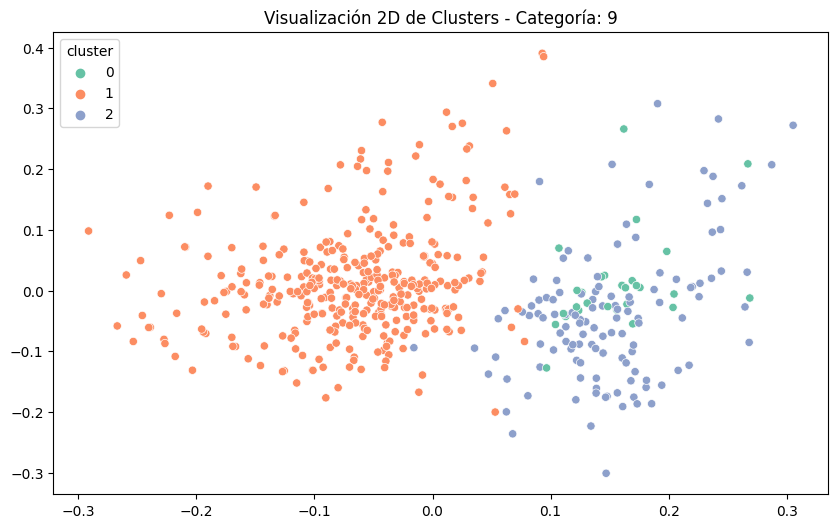

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reducci√≥n de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# A√±adir la columna de clusters al DataFrame
df_sample['cluster'] = kmeans.labels_

# Crear un gr√°fico de dispersi√≥n 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_sample['cluster'], palette='Set2', legend='full')
plt.title(f"Visualizaci√≥n 2D de Clusters - Categor√≠a: {categoria_a_numero[categoria]}")
plt.show()


Grafico del m√©todo de Elbow para verificar la evoluci√≥n de la suma de los cuadrados del error para varios valores de K y analizar cual es el que brinda un mejor agrupamiento.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


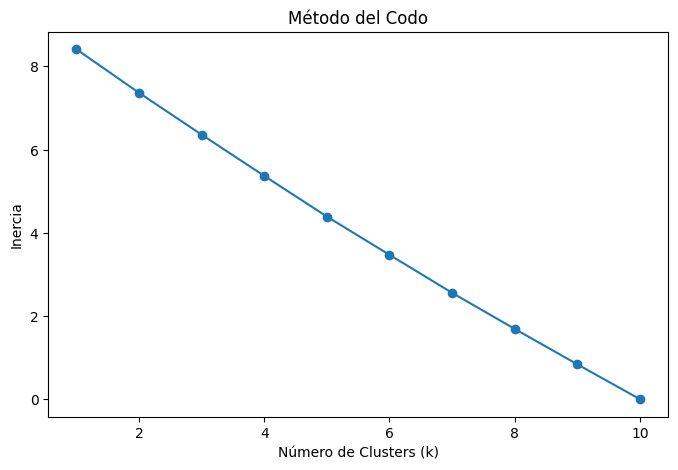

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Lista para almacenar las inercias
inertias = []

# Probar diferentes valores de k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)

# Graficar el m√©todo del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('M√©todo del Codo')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('Inercia')
plt.show()


Ahora con el √≠ndice de Silhouette.  Con k entre 2 y 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2, silhouette score is 0.01771306284173039


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3, silhouette score is 0.014880127311028557


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4, silhouette score is 0.017628426601486172


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5, silhouette score is 0.02044759372498691


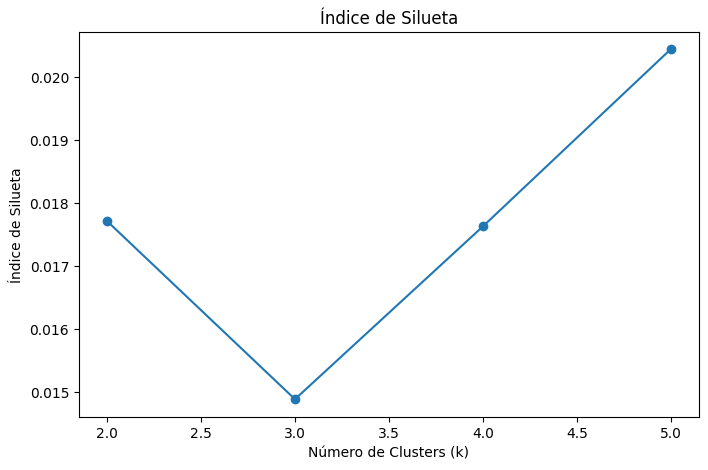

In [28]:
from sklearn.metrics import silhouette_score

# Lista para almacenar los valores de √≠ndice de silueta
silhouette_scores = []

# Probar diferentes valores de k
list_k = list(range(2, 6))  # Ajusta seg√∫n sea necesario
for n_clusters in list_k:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_tfidf)

    # Asegurarse de que haya m√°s de un cluster para calcular el √≠ndice de silueta
    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(X_tfidf, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg}")
    else:
        print(f"For n_clusters = {n_clusters}, cannot calculate silhouette score with only one cluster.")

# Graficar el √≠ndice de silueta
plt.figure(figsize=(8, 5))
plt.plot(list_k, silhouette_scores, marker='o')
plt.title('√çndice de Silueta')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('√çndice de Silueta')
plt.show()


Grafico de silueta para k=2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


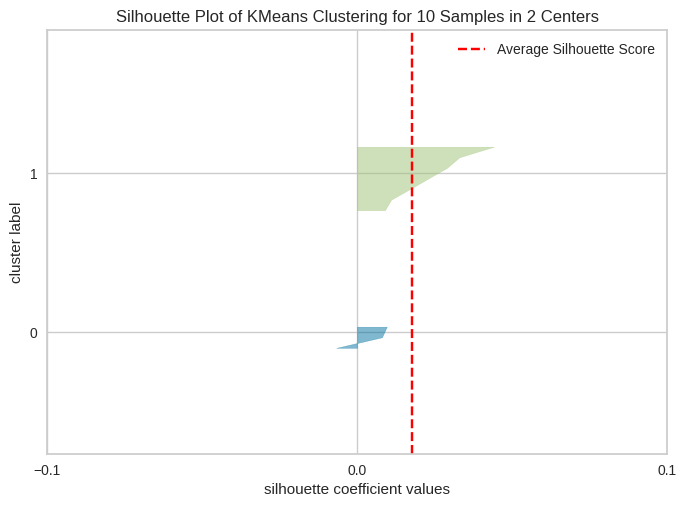

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
from yellowbrick.cluster import SilhouetteVisualizer

# N√∫mero de clusters en este caso es 2 para probar
num_clusters = 2

# Inicializar el modelo de k-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_tfidf)

# Utilizar SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_tfidf)
visualizer.show()


Grafico de silueta para k=4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


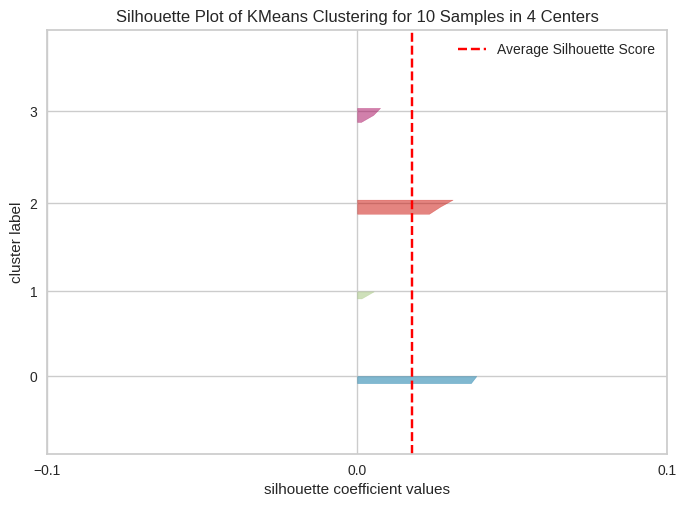

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [35]:
from yellowbrick.cluster import SilhouetteVisualizer

# N√∫mero de clusters en este caso es 2 para probar
num_clusters = 4

# Inicializar el modelo de k-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_tfidf)

# Utilizar SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_tfidf)
visualizer.show()
